# Faiman model

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.graph_objs as go
from pvanalytics import quality
from pvlib import temperature

## Importing data

In [2]:
#readcsv
df = pd.read_csv("df_hourly")

if not isinstance(df["Timestamp"], pd.DatetimeIndex):
        df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df.set_index("Timestamp", inplace=True)

In [3]:
df.columns

Index(['PT JKM325 nr 1 [°C]', 'PT JKM325 nr 2 [°C]', 'PT JKM325 nr 3 [°C]',
       'PT JKM335 nr 1 [°C]', 'PT JKM335 nr 2 [°C]', 'PT JKM335 nr 3 [°C]',
       'PT REC nr 1 [°C]', 'PT REC nr 2 [°C]', 'PT REC nr 3 [°C]',
       'PT SunP nr 1 [°C]', 'PT SunP nr 2 [°C]', 'PT SunP nr 3 [°C]',
       'PT Talesun 1 [°C]', 'PT Talesun 2 [°C]', 'PT Talesun 3 [°C]',
       'PT Talesun FrLess 1 [°C]', 'PT Talesun FrLess 2 [°C]',
       'PT Talesun FrLess 3 [°C]', 'Irradiance (IRR Hor - SunP) [W/m²]',
       'Irradiance (IRR Plan - SunP) [W/m²]',
       'Irradiance (IRR Plan - Talesun) [W/m²]',
       'Irradiance (IRR Plan - JKM325) [W/m²]',
       'Irradiance (IRR Plan - JKM335) [W/m²]',
       'Irradiance (SMP10 Sunpower plan) [W/m²]',
       'Irradiance (SMP10 Sunpower horisontal) [W/m²]',
       'Irradiance (SMP10 Talesun albedo) [W/m²]',
       'Irradiance (SMP10 Talesun plan) [W/m²]',
       'Irradiance (KippZonen SMP10 20201023) [W/m²]',
       'WS500_1_Air pressure abs [hPa]', 'WS500_1_Air

### Plotting function

In [4]:
import matplotlib.dates as mdates

def plot_comparison(x, temp_model, temp_measured, module_name):
    if not isinstance(x, pd.DatetimeIndex):
        x = pd.to_datetime(x)

    #x = x.asfreq('h')

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9, 6), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
    ax1.set_title(f"Model prediction and measured temperature for {module_name}")
    ax1.plot(x, temp_model, label="Faiman module temperature")
    ax1.plot(x, temp_measured, label="Measured module temperature")
    ax1.set_ylabel("[°C]")
    #ax2.set_title("Residuals")
    ax2.plot(x, temp_model-temp_measured)
    ax2.set_ylabel("Residuals [°C]")
    ax2.axhline(0, c="grey", linestyle=":")
    ax1.legend()
    ax2.xaxis.set_major_locator(mdates.AutoDateLocator())  
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha="right") 
    plt.tight_layout()
    plt.show()

## Faiman model

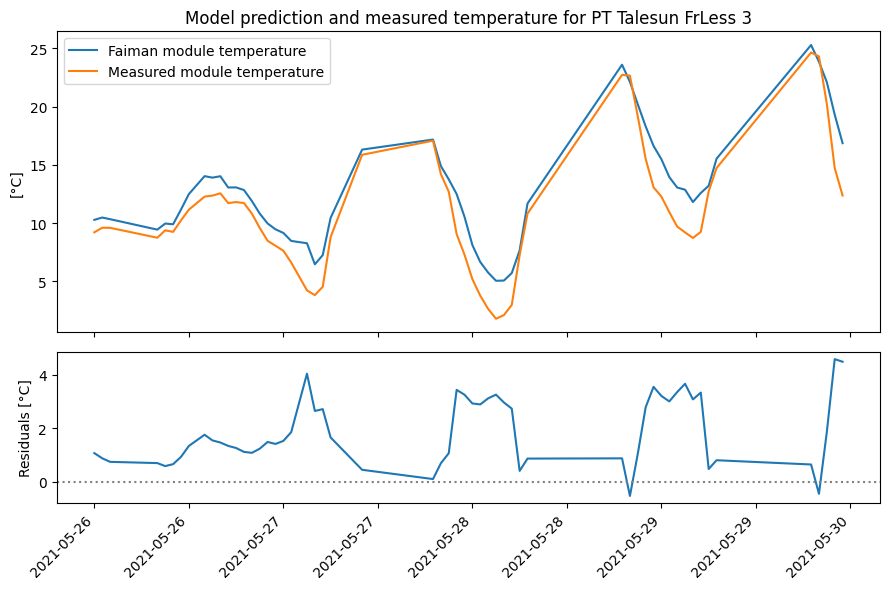

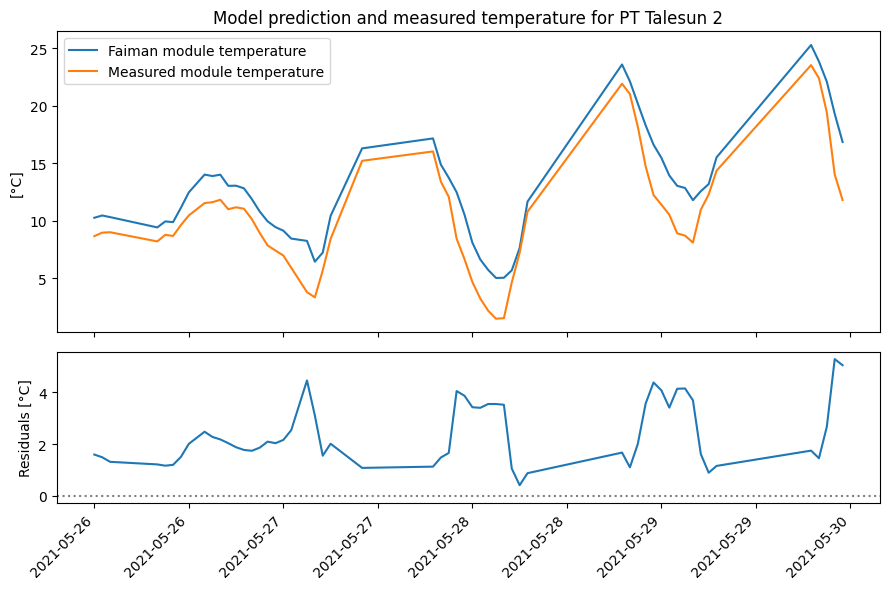

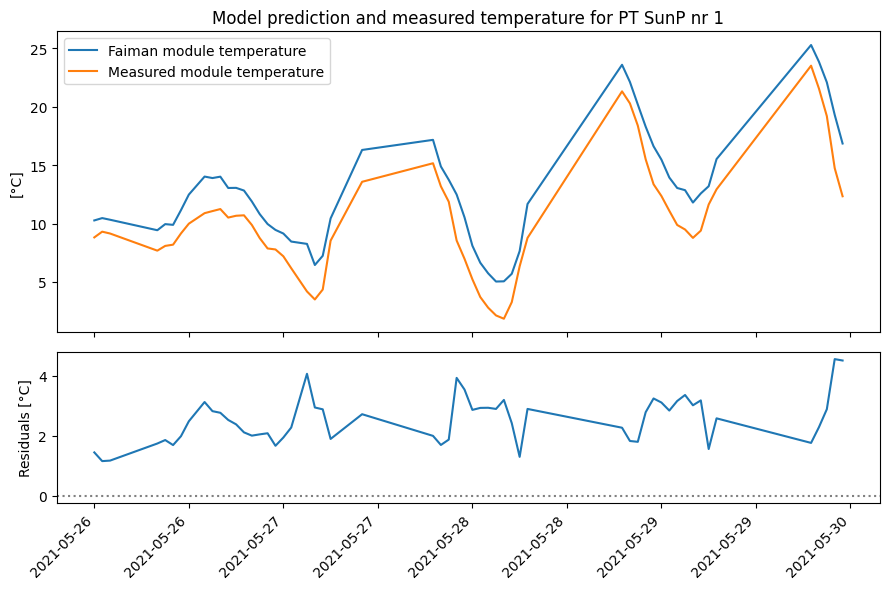

In [15]:
datea = '2021-05-26'
dateb = '2021-05-29'

#Bifacial panel
temp_faiman1 = temperature.faiman(df["Irradiance (IRR Plan - Talesun) [W/m²]"], df["WS500_1_Temperature [°C]"], df["WS500_1_Wind speed [m/s]"])
plot_comparison(df.loc[datea:dateb].index, temp_faiman1.loc[datea:dateb], df["PT Talesun FrLess 3 [°C]"].loc[datea:dateb], "PT Talesun FrLess 3")
temp_faiman2 = temperature.faiman(df["Irradiance (IRR Plan - Talesun) [W/m²]"], df["WS500_1_Temperature [°C]"], df["WS500_1_Wind speed [m/s]"])
plot_comparison(df.loc[datea:dateb].index, temp_faiman2.loc[datea:dateb], df["PT Talesun 2 [°C]"].loc[datea:dateb], "PT Talesun 2")
#Normal panel
temp_faiman3 = temperature.faiman(df["Irradiance (IRR Plan - SunP) [W/m²]"], df['PT SunP nr 1 [°C]'], df["WS500_1_Wind speed [m/s]"])
plot_comparison(df.loc[datea:dateb].index, temp_faiman2.loc[datea:dateb], df['PT SunP nr 1 [°C]'].loc[datea:dateb], "PT SunP nr 1")

Ser at for bifacial bommer den både på topp og bunn, mens for en-sidige paneler treffer den veldig godt i bunnen men over-estimerer i toppen (midt på dagen). 

## Mean bias error

In [6]:
def MBE(model_results, measured_temp): 
    df_temp = pd.DataFrame({'model_results': model_results, 'measured_temp': measured_temp})
    df_temp = df_temp.dropna(how="any")

    #Calculating RMSE
    mbe = (1/len(df_temp["model_results"])) * np.sum(df_temp["model_results"] - df_temp["measured_temp"]) #np.sqrt(((df_temp["model_results"] - df_temp["measured_temp"])**2).mean())
    return mbe

In [7]:
#Bifacial
print(MBE(temp_faiman1, df["PT Talesun FrLess 3 [°C]"]))
print(MBE(temp_faiman2, df["PT Talesun 2 [°C]"]))
#Monofacial
print(MBE(temp_faiman3, df['PT SunP nr 1 [°C]']))

1.3962554552594115
2.1263553699682745
0.9468145033699598


## Looking into RMSE

In [8]:
#RMSE
def rmse(model_results, measured_temp):
    df_temp = pd.DataFrame({'model_results': model_results, 'measured_temp': measured_temp})
    df_temp = df_temp.dropna(how="any")

    #Calculating RMSE
    rmse = np.sqrt(((df_temp["model_results"] - df_temp["measured_temp"])**2).mean())
    return rmse

#Bifacial
print(rmse(temp_faiman1, df["PT Talesun FrLess 3 [°C]"]))
print(rmse(temp_faiman2, df["PT Talesun 2 [°C]"]))
#Monofacial
print(rmse(temp_faiman2, df['PT SunP nr 1 [°C]']))

2.0969068816313126
2.621359213126091
2.5993119046380255


Videre:

Looking into RMSE for all bifacial measurements and all monofacial?

Or all the panel types, see which models works best for each model type?

#### Calculating and saving values for comparison

In [9]:
df.columns

Index(['PT JKM325 nr 1 [°C]', 'PT JKM325 nr 2 [°C]', 'PT JKM325 nr 3 [°C]',
       'PT JKM335 nr 1 [°C]', 'PT JKM335 nr 2 [°C]', 'PT JKM335 nr 3 [°C]',
       'PT REC nr 1 [°C]', 'PT REC nr 2 [°C]', 'PT REC nr 3 [°C]',
       'PT SunP nr 1 [°C]', 'PT SunP nr 2 [°C]', 'PT SunP nr 3 [°C]',
       'PT Talesun 1 [°C]', 'PT Talesun 2 [°C]', 'PT Talesun 3 [°C]',
       'PT Talesun FrLess 1 [°C]', 'PT Talesun FrLess 2 [°C]',
       'PT Talesun FrLess 3 [°C]', 'Irradiance (IRR Hor - SunP) [W/m²]',
       'Irradiance (IRR Plan - SunP) [W/m²]',
       'Irradiance (IRR Plan - Talesun) [W/m²]',
       'Irradiance (IRR Plan - JKM325) [W/m²]',
       'Irradiance (IRR Plan - JKM335) [W/m²]',
       'Irradiance (SMP10 Sunpower plan) [W/m²]',
       'Irradiance (SMP10 Sunpower horisontal) [W/m²]',
       'Irradiance (SMP10 Talesun albedo) [W/m²]',
       'Irradiance (SMP10 Talesun plan) [W/m²]',
       'Irradiance (KippZonen SMP10 20201023) [W/m²]',
       'WS500_1_Air pressure abs [hPa]', 'WS500_1_Air

In [10]:
temp_faiman1 = temperature.faiman(df['Irradiance (IRR Plan - JKM325) [W/m²]'], df["WS500_1_Temperature [°C]"], df["WS500_1_Wind speed [m/s]"])
temp_faiman2 = temperature.faiman(df['Irradiance (IRR Plan - JKM335) [W/m²]'], df["WS500_1_Temperature [°C]"], df["WS500_1_Wind speed [m/s]"])
temp_faiman3 = temperature.faiman(df['Irradiance (IRR Plan - SunP) [W/m²]'], df["WS500_1_Temperature [°C]"], df["WS500_1_Wind speed [m/s]"])
temp_faiman4 = temperature.faiman(df['Irradiance (IRR Plan - SunP) [W/m²]'], df["WS500_1_Temperature [°C]"], df["WS500_1_Wind speed [m/s]"])
temp_faiman5 = temperature.faiman(df['Irradiance (IRR Plan - Talesun) [W/m²]'], df["WS500_1_Temperature [°C]"], df["WS500_1_Wind speed [m/s]"])
temp_faiman6 = temperature.faiman(df['Irradiance (IRR Plan - Talesun) [W/m²]'], df["WS500_1_Temperature [°C]"], df["WS500_1_Wind speed [m/s]"])

In [11]:
module_names = ["PT JKM325 nr 3", "PT JKM335 nr 3", "PT SunP nr 2", "PT REC nr 3", "PT Talesun FrLess 1",  "PT Talesun 3"]

MBE1 = MBE(temp_faiman1, df["PT JKM325 nr 3 [°C]"])
MBE2 = MBE(temp_faiman2, df["PT JKM335 nr 3 [°C]"])
MBE3 = MBE(temp_faiman3, df['PT SunP nr 2 [°C]'])
MBE4 = MBE(temp_faiman4, df['PT REC nr 3 [°C]'])
MBE5 = MBE(temp_faiman5, df["PT Talesun FrLess 1 [°C]"])
MBE6 = MBE(temp_faiman6, df["PT Talesun 3 [°C]"])

In [12]:
RMSE1 = rmse(temp_faiman1, df["PT JKM325 nr 3 [°C]"])
RMSE2 = rmse(temp_faiman2, df["PT JKM335 nr 3 [°C]"])
RMSE3 = rmse(temp_faiman3, df['PT SunP nr 2 [°C]'])
RMSE4 = rmse(temp_faiman4, df['PT REC nr 3 [°C]'])
RMSE5 = rmse(temp_faiman5, df["PT Talesun FrLess 1 [°C]"])
RMSE6 = rmse(temp_faiman6, df["PT Talesun 3 [°C]"])

In [13]:
results = pd.DataFrame({
    "Module": module_names,
    "RMSE": [RMSE1, RMSE2, RMSE3, RMSE4, RMSE5, RMSE6],
    "MBE": [MBE1, MBE2, MBE3, MBE4, RMSE5, RMSE6]
})

In [14]:
results.to_csv('Faiman_results.csv', index=False)